# Political Twitter Tweet Trends

Andrew Chai, Nicholas Saldana, Olin Zhou


# Introduction
With the growing need for an online presence in politics, the accounts of those running for public office become more and more important. Here we are looking at the defining characteristics of the two presidential candidates for the 2020 election.


The goal of this analysis is to 

1.   look at how each candidate are appealing to voters
2.   the key issues each candidate address
3.   general statistics of each candidate’s Twitter activity



In [2]:
#import stuff
import pandas  as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import spacy 
from textstat.textstat import textstatistics, legacy_round, textstat
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data
Our Tweets dataset is from Kaggle.

*   https://www.kaggle.com/rohanrao/joe-biden-tweets (Biden Tweets)
*   https://www.kaggle.com/austinreese/trump-tweets (Trump Tweets)

Here we are cleaning the data by removing some of the stopwords. Stop words include words in the english stopwords library and some of the ones we found in the Tweets.

Some problems with our dataset we fixed and considered are

*   Uneven dataset with Trump having ~50,000 Tweets while Biden only having ~5,000 tweets
*   Uneven dataset leads to difficulty evaluating models
*   Inconsistent time ranges between the two candidates

We will talk about how we fixed these probems throughout this notebook.




In [3]:
# read data
joe_data = pd.read_csv('data/JoeBidenTweets.csv')
donald_data = pd.read_csv('data/realdonaldtrump.csv')

joe_tweets = joe_data['tweet']
donald_tweets = donald_data['content']

In [4]:
cachedStopWords = stopwords.words('english')
cachedStopWords.append('@')
cachedStopWords.append('"')
cachedStopWords.append('i')
cachedStopWords.append('realdonaldtrump')
cachedStopWords.append('#')
cachedStopWords.append('&')
cachedStopWords.append('the')
cachedStopWords.append('…')
cachedStopWords.append('-')
cachedStopWords.append('—')
cachedStopWords.append('it’s')
cachedStopWords.append('get')
cachedStopWords.append('trump')
cachedStopWords.append('make')
cachedStopWords.append('president')
cachedStopWords.append('.')


top_joe_words = Counter([word for word in " ".join(joe_tweets).lower().split() if word not in cachedStopWords])
top_donald_words = Counter([word for word in " ".join(donald_tweets).lower().split() if word not in cachedStopWords])

features = 'problems, today, protecting, seniors, important, healthcare, people, point, trump, thanks, mexico, polls, illegal, closing, immigration, family, clinton, biden'

for feature in features.split(', '):
  print(feature + ": ")
  print(top_joe_words.get(feature))
  print(top_donald_words.get(feature))

problems: 
2
98
today: 
199
572
protecting: 
17
49
seniors: 
5
6
important: 
80
265
healthcare: 
2
111
people: 
407
2114
point: 
11
148
trump: 
None
None
thanks: 
38
862
mexico: 
6
212
polls: 
12
170
illegal: 
None
306
closing: 
5
34
immigration: 
25
218
family: 
77
196
clinton: 
5
390
biden: 
443
77


# Preliminary Visualization

Here we want to take a look at some of the general statistics each candidate has in regards to their Tweets.

These statistics are 

*   Tweet date ranges
*   General word choices (wordcloud)
*   Word count per Tweet
*   Popularity (retweets and likes per Tweet)
*   Readability (Dale-Chall readability score)



Joe Biden Tweet dates

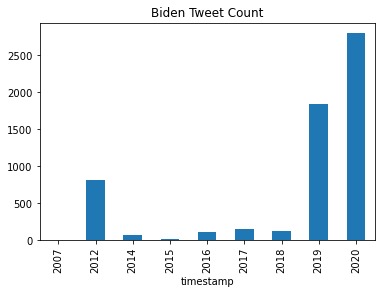

In [5]:
# joe dates

joe_dates = joe_data['timestamp']
joe_dates = joe_dates.astype("datetime64")

joe_dates.groupby([joe_dates.dt.year]).count().plot(kind="bar", title='Biden Tweet Count')


Donald Trump Tweet dates

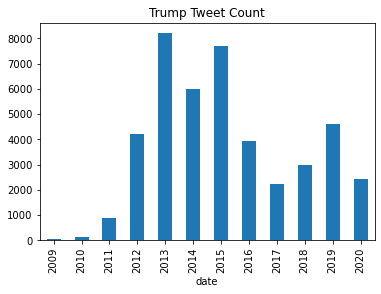

In [6]:
# donald dates

donald_dates = donald_data['date']
donald_dates = donald_dates.astype("datetime64")

donald_dates.groupby([donald_dates.dt.year]).count().plot(kind="bar", title='Trump Tweet Count')


Joe Biden wordcloud

In [9]:
# word cloud

# create mask
joe_mask = np.array(Image.open('data/wordcloud/joeshape.jpg'))

morestopwords = set(STOPWORDS)
morestopwords.add('https')
morestopwords.add('com')
morestopwords.add('html')
morestopwords.add('re')
morestopwords.add('realDonaldTrump')
morestopwords.add('bit')
morestopwords.add('ly')
morestopwords.add('s')
morestopwords.add('t')
morestopwords.add('pic')
morestopwords.add('twitter')

stopwords = text.ENGLISH_STOP_WORDS.union(morestopwords)

def blue_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(49,51))

wc = WordCloud(width=800, height=400, background_color="white", max_words=1000, mask=joe_mask, stopwords=stopwords)
wc.generate(' '.join(joe_tweets))

wc.recolor(color_func = blue_color_func)

wc.to_file('images/joecloud.png')

# plt.figure(figsize=(8,6), dpi=2000)
# plt.imsave('images/joecloud.png', wc, interpolation='bilinear')
# plt.axis("off")



Donald Trump wordcloud

In [11]:
# word cloud

# create mask
trump_mask = np.array(Image.open('data/wordcloud/trumpshape.jpg'))

def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%%, %d%%)" % np.random.randint(49,51))

wc = WordCloud(width=800, height=400, background_color="white", max_words=1000, mask=trump_mask, stopwords=stopwords)
wc.generate(' '.join(donald_tweets))

wc.recolor(color_func = red_color_func)

wc.to_file('images/donaldcloud.png')


Word count for each candidate

Average Joe word count: 30.075821398483573
Average Donald word count: 20.76280217752353


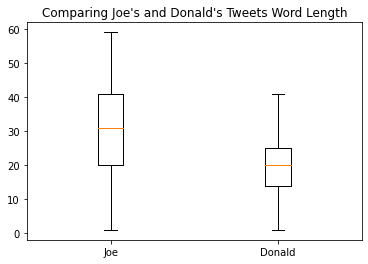

In [12]:
# word count

joe_counts = []
for tweet in joe_tweets:
  word_count = len(tweet.split())
  joe_counts.append(word_count)

print('Average Joe word count: ' + str(sum(joe_counts) / len(joe_counts)))

donald_counts = []
for tweet in donald_tweets:
  word_count = len(tweet.split())
  donald_counts.append(word_count)

print('Average Donald word count: ' + str(sum(donald_counts) / len(donald_counts)))

word_counts = []
word_counts.append(joe_counts)
word_counts.append(donald_counts)

plt.boxplot(word_counts, showfliers=False)
plt.title('Comparing Joe\'s and Donald\'s Tweets Word Length')
plt.xticks([1, 2], ['Joe', 'Donald'])
plt.show()

Retweets and likes for each candidate

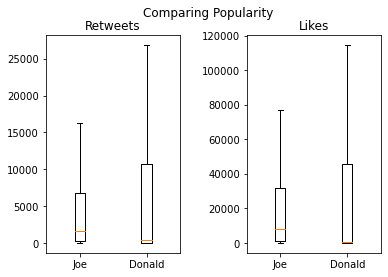

In [13]:
# popularity

joe_retweets = joe_data['retweets']
joe_likes = joe_data['likes']

donald_retweets = donald_data['retweets']
donald_likes = donald_data['favorites']

retweets_data = []
retweets_data.append(joe_retweets)
retweets_data.append(donald_retweets)

likes_data = []
likes_data.append(joe_likes)
likes_data.append(donald_likes)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparing Popularity')

ax1.boxplot(retweets_data, showfliers=False)
ax1.set_title('Retweets')
ax1.set_xticklabels(['Joe', 'Donald'])

ax2.set_title('Likes')
ax2.set_xticklabels(['Joe', 'Donald'])
ax2.boxplot(likes_data, showfliers=False)

plt.subplots_adjust(wspace=0.5)

plt.show()

#Readability for each candidate

We evalueated each tweet using the Flesch-Kincaid readability score, and took the average score for all of each candidate's tweets.  The higher the score, the easier their tweets are to read.



100.0–90.0	---	Very easy to read. Easily understood by an average 11-year-old student.

90.0–80.0	-----	Easy to read. Conversational English for consumers.

80.0–70.0	-----	Fairly easy to read.

70.0–60.0	-----	Plain English. Easily understood by 13- to 15-year-old students.

60.0–50.0	-----	Fairly difficult to read.

50.0–30.0	-----	Difficult to read.

30.0–10.0	-----	Very difficult to read.

In [14]:
# readability

joegrade = joe_tweets.apply(textstat.flesch_reading_ease)
grade_sum = 0
for tweetgrade in joegrade:
    grade_sum = grade_sum + tweetgrade
#print(grade_sum)
joereadinggrade = grade_sum / len(joegrade)
print("Joe Biden average readability score: ",joereadinggrade,"\n")

donaldgrade = donald_tweets.apply(textstat.flesch_reading_ease)
grade_sum = 0
for tweetgrade in donaldgrade:
    grade_sum = grade_sum + tweetgrade
#print(grade_sum)
donaldreadinggrade = grade_sum / len(donaldgrade)
print("Donald Trump average readability score: ",donaldreadinggrade)

Joe Biden average readability score:  59.564763268744834 

Donald Trump average readability score:  36.39489435320036


# Model Selection

We used and compared three different models for classifying the Tweets

1.   Naive Bayes
2.   Random Forest
3.   K Nearest Neighbors

We wanted to explore the key differences in these models and pick out the best one using the metrics they generate. 

The three metrics we used are

1.   Accuracy score
2.   Precision score
3.   Recall score

Since the dataset was uneven, accuracy is not as useful as the other two scores. We evaluated our models based on their precision and recall scores.





Naive Bayes model

Accuracy score:  0.9794676188930368
Precision score:  0.9831223628691983
Recall score:  0.9936034115138592


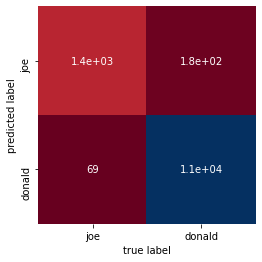

In [15]:
# naive bayes
# https://towardsdatascience.com/naive-bayes-document-classification-in-python-e33ff50f937e

# create labels

joe_df = joe_tweets.to_frame()
donald_df = donald_tweets.to_frame()
donald_df = donald_df.rename(columns={"content": "tweet"})
joe_df['label'] = 0
donald_df['label'] = 1

# combine into one dataframe

tweets = [joe_df, donald_df]
tweet_df = pd.concat(tweets)

tweet_df = tweet_df[tweet_df['tweet'] != 0]
tweet_df = tweet_df[tweet_df['tweet'] != 1]

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(tweet_df['tweet'], tweet_df['label'], random_state=1)

# convert into count vector
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# fit model

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)

# check scores 

print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))

# confusion matrix

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['joe', 'donald'], yticklabels=['joe', 'donald'])
plt.xlabel('true label')
plt.ylabel('predicted label')

# investigating misses

testing_predictions = []
for i in range(len(X_test)):
    if predictions[i] == 1:
        testing_predictions.append('donald')
    else:
        testing_predictions.append('joe')
check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions, 'abstract':list(X_test)})
check_df.replace(to_replace=0, value='joe', inplace=True)
check_df.replace(to_replace=1, value='donald', inplace=True)

miss_df = check_df[check_df['actual_label'] != check_df['prediction']]

miss_df.to_csv('miss_label.csv')

K nearest neighbors model

Accuracy score:  0.9433533517286155
Precision score:  0.9405292114225832
Recall score:  0.9984240289237044


Text(91.68, 0.5, 'predicted label')

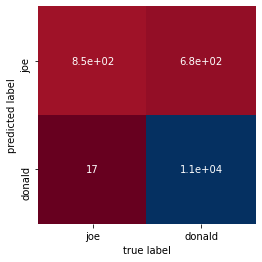

In [16]:

joe_df = joe_tweets.to_frame()
donald_df = donald_tweets.to_frame()
donald_df = donald_df.rename(columns={"content": "tweet"})
joe_df['label'] = 0
donald_df['label'] = 1

# combine into one dataframe

tweets = [joe_df, donald_df]
tweet_df = pd.concat(tweets)

tweet_df = tweet_df[tweet_df['tweet'] != 0]
tweet_df = tweet_df[tweet_df['tweet'] != 1]

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(tweet_df['tweet'], tweet_df['label'], random_state=1)

# convert into count vector
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# create K nearest neighbors model
KNN = KNeighborsClassifier(n_neighbors=25)
KNN.fit(X_train_cv, y_train)
predictions = KNN.predict(X_test_cv)


print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['joe', 'donald'], yticklabels=['joe', 'donald'])
plt.xlabel('true label')
plt.ylabel('predicted label')

Random forest model

Accuracy score:  0.9784937510144457
Precision score:  0.9775780682643428
Recall score:  0.9983313247427459
Important features:
['chinese', 'war', 'w', 'syrians', 'syrian', 'http', 'ly', 'laughing', 'horrific', 'fl', 'victims', 'stop', 'smart', 'simple', 'donald', 'failed', 'america', 'trying', 'great', 'trumpgolf', 'respected', 'odyssey', 'trumpdoral', 'monster', 'redesign', 'today', 'fallen', 'years', 'vet', 'twitter']


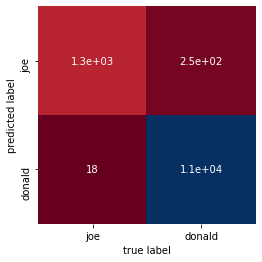

In [17]:
rfc = RandomForestClassifier()
rfc.fit(X_train_cv, y_train)
rfcpred = rfc.predict(X_test_cv)

# confusion matrix

rfcm = confusion_matrix(y_test, rfcpred)
sns.heatmap(rfcm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['joe', 'donald'], yticklabels=['joe', 'donald'])
plt.xlabel('true label')
plt.ylabel('predicted label')

print('Accuracy score: ', accuracy_score(y_test, rfcpred))
print('Precision score: ', precision_score(y_test, rfcpred))
print('Recall score: ', recall_score(y_test, rfcpred))

# investigating misses

rfc_test_pred = []
for i in range(len(X_test)):
    if rfcpred[i] == 1:
        rfc_test_pred.append('donald')
    else:
        rfc_test_pred.append('joe')
check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': rfc_test_pred, 'abstract':list(X_test)})
check_df.replace(to_replace=0, value='joe', inplace=True)
check_df.replace(to_replace=1, value='donald', inplace=True)

rfc_miss_df = check_df[check_df['actual_label'] != check_df['prediction']]

importances = list(rfc.feature_importances_)
#print(len(importances))
impf = [];
voc = cv.vocabulary_
for x in range(30):
    m = importances.index(max(importances))
    word = tuple(cv.vocabulary_.items())[x][0]
    impf.append(word)
    importances.remove(max(importances))
    voc.pop(word)
print("Important features:")
print(impf)

# Improving Current Models

We want to see if we can improve our current model.

We will first explore the idea of only using recent Tweets. This will narrow each candidate's goals and tweets to only recent events.


Using more recent Tweet data

In [18]:
joe_recent_data = joe_data[joe_data['timestamp'] > '2018-00-00 00:00']
donald_recent_data = donald_data[donald_data['date'] > '2018-00-00 00:00:00']

joe_recent_tweets = joe_recent_data['tweet']
donald_recent_tweets = donald_recent_data['content']

print('Joe Tweet Count: ' + str(len(joe_recent_tweets)))
print('Donald Tweet Count: ' + str(len(donald_recent_tweets)))


Joe Tweet Count: 4775
Donald Tweet Count: 10004


Accuracy score:  0.9807848443843031
Precision score:  0.9854427820460978
Recall score:  0.98584142394822


Text(91.68, 0.5, 'predicted label')

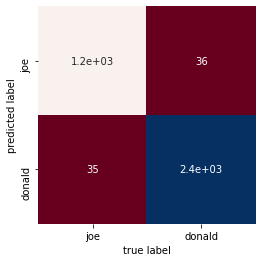

In [19]:
# naive bayes model

joe_df = joe_recent_tweets.to_frame()
donald_df = donald_recent_tweets.to_frame()
donald_df = donald_df.rename(columns={"content": "tweet"})
joe_df['label'] = 0
donald_df['label'] = 1

# combine into one dataframe

tweets = [joe_df, donald_df]
tweet_df = pd.concat(tweets)

tweet_df = tweet_df[tweet_df['tweet'] != 0]
tweet_df = tweet_df[tweet_df['tweet'] != 1]

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(tweet_df['tweet'], tweet_df['label'], random_state=1)

# convert into count vector
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# fit model

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)

# check scores 

print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))

# confusion matrix

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['joe', 'donald'], yticklabels=['joe', 'donald'])
plt.xlabel('true label')
plt.ylabel('predicted label')

As we see from the metrics, the model did not improve from the previous models. This may be due to a smaller testing set.